# MATH50003 (2025–26)
# Lab 1: I.1 Rectangular Rule and I.2 Divided Differences

Numerical analysis primarily studies the mathematical construction and analysis of algorithms
for approximating solutions to continuous problems like computing integrals or solving differential equations.
It is fundamental to the area to also understand how to implement such algorithms
in software. In year 1 you learned basic programming concepts such as loops, conditions,
functions, etc. and in this first lab we will employ these concepts in the implementation
of some basic approximations you have already seen in the guise of analysis.
In particular, we will look at the following:

1. Integration via the rectangular rule:  integrals are defined by approximating a function by rectangles and taking the limit as the number of rectangles becomes infinite. If we use a finite number of rectangles this gives an approximation to the integral.
2. Differentiation via divided differences: derivatives are defined by taking the limit of the difference of a function evaluated at two nearby points and dividing by the distance of these points, where in the limit the distance goes to zero. If we fix the distance to be small but nonzero we get an approximation to the derivative.

An important component to numerical analysis is studying the _convergence  rate_:
how fast do these approximations tend to the true value? We explore this question
here experimentally, leaving rigorous analysis to the problem sheet.

However, things do not go quite according to plan: our numerical implementation
does not quite follow the convergence results in analysis.
We run into a couple mysteries:

1. Numerical integration appears to converge but in some examples the error gets stuck at a vey small value, less than $10^{-15}$ or so.
2. Numerical differentiation appears to converges as $h → 0$ achieving around 5 digits or so. However, it starts becoming extremely inaccurate when $h$ falls below $10^{-8}$ or so, eventually giving no digits of accuracy!

In the next lab we will look at a work-around for mystery (2). And in the next few weeks
we will build an understanding of how computers work with numbers so that we can understand
why our algorithms "failed".

We will use the Julia programming language which is in some ways similar to Python.
Julia is a _compiled language_ whereas Python is interpreted. It is also more adapted to the
implementation of algorithms in numerical analysis and scientific computing.
Being a compiled language means it will help us later on in the module understand exactly how
the computer functions when performing numerical calculations.

We have included problems interspersed with the material which are highly recommended for
preparation for the computer-based exam later this term. Note each exercise comes with
unit-tests: if when run they don't throw an error that gives evidence (but no guarantee!)
that the problem solution is correct.

**Learning Outcomes**

Mathematical knowledge:

1. Approximating integrals using rectangular and trapezium rules.
2. Approximating (first) derivatives using divided differences and central differences.
3. Approximating second derivatives using second-order divided differences.
4. Understanding that there are artificial errors introduced by numerical implementations of algorithms.

Coding knowledge:

1. Turning a sum into a for-loop.
2. Making a function 3 ways: (1) a named function beginning `function f(x)`, an
(2) an anonymous function of the form `x -> ...` and (3) a named function but one one line via `f(x) = ...`
3. Plotting errors of a numerical approximation with log-scaled axes.
4. Interpreting a log-log plot to estimate the algebraic convergence rate of an approximation.

------

## I.1 Integration via rectangular rules

One possible definition for an integral is the limit of a Riemann sum, for example:
$$
  ∫_0^1 f(x) {\rm d}x = \lim_{n → ∞} {1 \over n} ∑_{j=1}^n f(j/n).
$$
This suggests an algorithm known as the _(right-sided) rectangular rule_
for approximating an integral: choose $n$ large so that
$$
  ∫_0^1 f(x) {\rm d}x ≈ {1 \over n} ∑_{j=1}^n f(j/n).
$$
To implement this approximation in code we need to turn the sum into a for-loop.
Let's take as an example $f(x) = \exp(x)$. We can write:

In [1]:
n = 10000     # the number of terms in the summation
ret = 0.0     # ret will store the result, accumulated one argument at a time.
              # The .0 makes it a "real" rather than an "integer".
              # Understanding the "type" will be important later on.
for j = 1:n   # j will be set to 1,2,…,n in sequence
    ret = ret + exp(j/n) # add exp(j/n) to the result. Now ret = ∑_{k = 1}^j f(k/n).
end           # in Julia for-loops are finished with an end
ret/n         # approximates the true answer exp(1) - exp(0) = ℯ-1 = 1.71828… to 4 digits

1.7183677439823704

It is convenient to wrap this in a function that takes in `f` and `n` and returns
the right-sided rectangular rule approximation. We can adapt the above routine into a function as follows:

In [1]:
function rightrectangularrule(f, n) # create a function named "rightrectangularrule" that takes in two arguments
    ret = 0.0
    for j = 1:n
        ret = ret + f(j/n) # now f is the input function
    end
    ret/n   # the last line of a function is returned
end # like for-loops, functions are finished with an end

rightrectangularrule(exp, 100_000_000) # Use n = 100 million points to get an approximation accurate to 8 digits.
                                       # The underscores in numbers are like commas and are ignored.

1.7182818370501693

In the problems below we provide unit-tests to help you verify whether your answers are correct.
This is provided by a `Test` package which provides the "macro" `@test` which either errors if a result
returns false or passes if it is true.  Here we test that our
implementation of `rightrectangularrule` approximately matches the true integral:

In [2]:
using Test # loads @test. Will need to be called again if you reset Julia
@test rightrectangularrule(exp, 100_000_000) ≈ exp(1) - 1

Test Passed

Note `≈` is a unicode character which can be typed as `\approx` followed by hitting the `[tab]` key.
The `@test` macro combined with `≈` allows us to provide an absolute tolerance which is useful
for checking results where the error is larger. Here we check that it satisfies the bound we have
proven:

In [3]:
n = 1000
@test rightrectangularrule(exp, n) ≈ exp(1) - 1 atol=exp(1)/n # error predicted to be less than M/n = (max exp(x))/n = exp(1)/n

Test Passed

Note it is now easy to approximate integrals of other functions. For example, the following code computes the
integral of $x^2$:

In [4]:
function squared(x)
    x^2 # carets ^ mean "to the power of". This is actually a function that just calls x*x.
end
@test rightrectangularrule(squared, 10_000) ≈ 1/3 atol=1E-4 # approximates 1/3 to 3 digits

Test Passed

Note below we sometimes use a one-liner version of defining a function:

In [5]:
squared(x) = x^2 # exactly the same as the `function squared(x) ... end` definition
@test rightrectangularrule(squared, 10_000) ≈ 1/3 atol=1E-4 # approximates 1/3 to 3 digits

Test Passed

It is often inconvenient to name a function, and so we might want to integrate a function like $\cos(x^2)$
by making a so-called anonymous function:

In [6]:
rightrectangularrule(x -> cos(x^2), 10_000) # No nice formula! But we expect from the theory that the error is less than 2*1E-4

0.9045012516131136

**Remark** Note the difference between "named" and "anonymous" functions can be confusing at first.
For example, writing `f = x -> cos(x^2)` creates an anonymous function and assigns it to the
variable `f`, which then behaves a lot like a named function in that we can call it _a la_ `f(0.1)`.
We can alternatively make a named function using the short-hand `g(x) = cos(x)^2`.
We will see later named functions have two special properties: (1) they behave like "constants",
and (2) named functions can have multiple definitions depending on the "type" of the input.

------

**Problem 1(a)** Complete the following function `leftrectangularrule(f, n)` That approximates
an integral using the left-sided rectangular rule:
$$
  ∫_0^1 f(x) {\rm d}x ≈ {1 \over n} ∑_{j=0}^{n-1} f(j/n).
$$
Hint: the easiest approach is to copy-and-paste the implementation of `rightrectangularrule`
and modify appropriately. You will have access to the labs during the computer-based exam,
and modifying code from the labs in the exam is completely acceptable.

In [8]:
using Test # Loads @test again in case you didn't run the line above.

function leftrectangularrule(f, n)
    ret = 0.0
    for j = 0:(n-1)
        ret = ret + f(j/n)
    end
    ret/n
end

@test leftrectangularrule(exp, 1000) ≈ exp(1) - 1 atol=1E-3 # tests that the approximation is accurate to 1E-3
@test leftrectangularrule(exp, 1000) < exp(1) - 1 < rightrectangularrule(exp, 1000) # These two routines bound the true answer. Why is this?

Test Passed

**Problem 1(b)** If we approximate integrals by _trapeziums_ instead of rectangles we arrive
at an approximation to an integral using the $(n+1)$-point trapezium rule:
$$
  ∫_0^1 f(x) {\rm d}x ≈ {1 \over n} \left[ f(0)/2 + ∑_{j=1}^{n-1} f(j/n) + f(1)/2 \right]
$$
Write a function `trapeziumrule(f, n)` that implements this approximation.
Do you think it is more or less accurate than the rectangular rules?

In [9]:
function trapeziumrule(f, n)
    ret = 0.0
    ret = (f(0) + f(1))/2
    for j = 1:(n-1)
        ret = ret + f(j/n)
    end
    ret/n
end
@test trapeziumrule(exp, 1000) ≈ exp(1) - 1 atol=1E-6

Test Passed

**Problem 1(c)** Compare `rightrectangularrule` and `trapeziumrule`
for $f(x)$ equal to $\cos(2πx)$ and $\sin(4πx)$ for $n = 1, 3, 5$. Mathematically,
should they return the same result? Do they in practice? Does the accuracy improve if we make `n = 10_000`?
Hint: It is possible to type `π` by typing `\pi` and then hitting the tab key. Otherwise one can just
type out `pi`.

In [17]:
function compareintegrationrules(f)
    nrange = [1,3,5,10_000]
    print([(rightrectangularrule(f,n), trapeziumrule(f,n)) for n in nrange])
end
compareintegrationrules(x -> cos(2*π*x))
compareintegrationrules(x -> cos(4*π*x))
#They don't equate when n = 5 (for the cosine function) or n = 10_000. 
#The accuracy also doesn't improve for n = 10_000, stuck around that 1e-16 to 1e-17 range.

[(1.0, 1.0), (-7.401486830834377e-17, -7.401486830834377e-17), (-4.4408920985006264e-17, -2.2204460492503132e-17), (-2.4358293160275936e-17, -1.4954704141700857e-17)][(1.0, 1.0), (1.1102230246251565e-16, 1.1102230246251565e-16), (0.0, 0.0), (-2.4469315462738452e-17, 8.715250743307479e-18)]

------

### I.1.2 Plotting errors in approximations

We have seen that the rectangular and trapezium rules are a convenient way to approximate values of
integrals. We can ask the question: which method is the most accurate? A natural way to address this
question is to investigate the _convergence rate_: find $α > 0$ such that there exists $C > 0$ so that
  $$
  |\hbox{Error}| ≤ C n^{-α}.
  $$
 It is possible to prove convergence rates
(something we will come back to throughout the module) but it is often easier and more informative
to plot the error and deduce the convergence rate experimentally.

Let's try with the `leftrectangularrule` routine. First we see how we can plot functions:

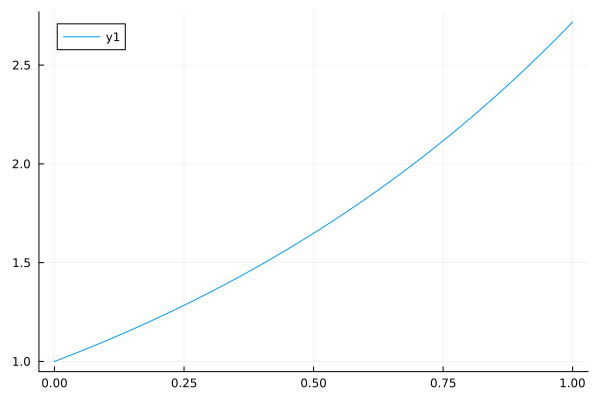

In [15]:
using Plots # Load the plotting package

m = 100 # number of plot points
x = range(0, 1; length=m) # makes a vector of a 100 points between 0 and 1
y = [exp(x[j]) for j=1:m] # Make a vector of exp evaluated at each point x.
plot(x, y) # plot lines throw the specified x and y coordinates

We now plot the absolute value of the integral approximated
by the left-hand rule compared to the "true" answer `exp(1)-1` as $n$ increases:

In [ ]:
N = 10_000 # total number of points
rightruleerr = n -> rightrectangularrule(exp,n)- (exp(1)-1) # anonymous function that computes the error in the right-hand rectangular rule for the exponential
errs = [abs(rightruleerr(n)) for n=1:N] # create a vector of the absolute-value of the errors for n running from 1 to N
plot(1:N, errs; label="right-rule error") # label="..." labels the plot in the legend

This plot is very uninformative: we can see that the error tends to zero but its
hard to understand at what rate. We can get more information by scaling both the $x$- and $y$-axis logarithmically:

In [ ]:
plot(1:N, errs; xscale=:log10, yscale=:log10, label="right-rule error", yticks=10.0 .^ (-10:1)) # yticks specifies the ticks used on the y-axis

We see with 10,000 points we get about $10^{-4}$ errors.
We can add to this plot reference curves corresponding to $n^{-1}$ and $n^{-2}$
to estimate the convergence rate:

In [ ]:
plot!(1:N, (1:N) .^ (-1); linestyle=:dash, label="n^-1") # exclamation point means add to existing plot
plot!(1:N, (1:N) .^ (-2); linestyle=:dash, label="n^-2")

Since the error decays at the same rate as $n^{-1}$ we conclude that we can likely bound the error by
$C n^{-1}$ for some constant $C$, which matches the theory.

------

**Problem 2(a)** Estimate the convergence rate for `trapeziumrule` for $f(x) = \exp x$ by plotting the
error where the $x$- and $y$-axis are scaled logarithmically.

In [ ]:
# TODO: Plot the absolute-value of the error of trapeziumrule for n = 1:10_000 and deduce the convergence rate

**Problem 2(b)** Estimate the convergence rate for `trapeziumrule` $f(x) = 1/(25\cos(2πx)^2+1)$, where you can
use `0.19611613513818404` as a high-accuracy value for the integral, by plotting the error for `n = 1:2000`.
Can you guess what property of this function makes the convergence rate so fast?
Does the error actually tend to zero?
Hint: plotting zeros with a log-scaled plot is problematic. Instead of calling `abs` use the function `nanabs`
provided here which turns these values into "not a number"s, which are omitted in plots.

In [ ]:
# nanabs(x) returns either abs(x) if it is greater than 0 or NaN
function nanabs(x)
    if x == 0
        NaN
    else
        abs(x)
    end
end

# TODO: Plot the absolute-value of the error of trapeziumrule with f = x -> 1/(25cos(2π*x)^2+1) for n = 1:2000.

-------

## I.2 Differentiation via divided differences

One possible definition for a derivative is the limit of a _divided difference_:
$$
f'(x) = \lim_{h → 0} {f(x + h) - f(x) \over h}
$$
This suggests an algorithm known as the _(right-sided) divided difference_
for approximating a derivative: choose $h$ small and then
$$
  f'(x) ≈ {f(x + h) - f(x) \over h}.
$$
We can implement this easily as a simple function. This
function is so simple we write it as a single line (using a special
syntax that is equivalent to writing `function ...`):

In [ ]:
rightdifferences(f, x, h) = (f(x+h) - f(x))/h # defines a function called rightdifferences(f, x, h) in one line
rightdifferences(exp, 1, 0.00001)

We have computed `ℯ = 2.71828...` to 5 digits. One might be tempted to compute the integral by
just setting `h = 0`:

In [ ]:
rightdifferences(exp, 1, 0)

Oh no! It returned `NaN`: this means "Not a Number", a place-holder when a calculation fails. Instead, let's try making `h`
very small:

In [ ]:
rightdifferences(exp, 1, 10.0^(-15))

The result is completely wrong! Let's do a plot of the error as $h → 0$:

In [ ]:
# Create  vector of errors in divided difference for h = 1,0.1,0.01,…,10^(-20)


errs = [abs(rightdifferences(exp, 1, 10.0^(-k))-exp(1)) for k = 0:20]
plot(0:20, errs; yscale=:log10, label="error", legend=:bottomright) # scale only the y-axis, move the legend to bottom right to get out of the way
bnds = [(h = 10.0^(-k); exp(1+h)*h/2) for k = 0:20] # error bound proven theoretically. We use ";" to write two lines at once
plot!(0:20, bnds; linestyle=:dash, label="bound")

This raises a couple of mysteries:
1. Why does our numerical version of divided differences diverges
even though theoretically it's guaranteed to converge?
2. Why is the optimal choice $h ≈ 10^{-8}$ (or more suggestively $h ≈ 2^{-26}$)?
In order to answer these mysteries we will need to understand how numbers work on a computer,
a topic we will come back to in the next few weeks.

------

**Problem 3(a)** An alternative to right-sided divided differences is the central differences approximation:
$$
f'(x) ≈ {f(x+h) - f(x-h) \over 2h}
$$
Complete the following function that returns the central difference approximation:

In [ ]:
function centraldifferences(f, x, h)
    # TODO: return an implementation of central differences

end

@test centraldifferences(exp, 1, 0.00001) ≈ exp(1) atol=1E-10

**Problem 3(b)** Plot the errors of central differences for computing $f'(1)$
for $f(x) = \exp x$ for `h = 1,0.1,…,10^(-20)`.
Does it converge? If not, approximately which value of $h$ gives the best approximation?
Which achieves better accuracy: `rightdifferences` or `centraldifferences`?

In [ ]:
# TODO: Plot the errors of centraldifferences

**Problem 3(c)** Applying central differences to itself we get an approximation to
second derivatives of the form:
$$
  f''(x) ≈ {f(x+h) - 2f(x) + f(x-h) \over h^2}
$$
Implement this approximation in a function `seconddifferences(f, x, h)`
and plot the error in approximating $f''(1)$, for $f(x) = \exp x$ with `h = 1,0.1,…,10^(-10)`.

In [ ]:
# TODO: implement seconddifferences(f,x,h) and plot the error for h = 1,0.1,…,10^(-10).

**Problem 3(d)** Use central differences to approximate to 5-digits the first
derivative to the following functions
at the point $x = 0.1$:
1. $\exp(\exp x \cos x + \sin x)$
2. $∏_{k=1}^{1000} \left({x \over k}-1\right)$
3. $f^{\rm s}_{1000}(x)$ where $f^{\rm s}_n(x)$ corresponds to $n$-terms of the following continued fraction:
$$
1 + {x-1 \over 2 + {x-1 \over 2 + {x-1 \over 2 + ⋱}}},
$$
e.g.:
$$f^{\rm s}_1(x) = 1 + {x-1 \over 2}$$
$$f^{\rm s}_2(x) = 1 + {x-1 \over 2 + {x -1 \over 2}}$$
$$f^{\rm s}_3(x) = 1 + {x-1 \over 2 + {x -1 \over 2 + {x-1 \over 2}}}$$
Hint: the challenge here is being confident that we have achieved 5 digits, even though
the question doesn't require a proof. If we vary `h` and the first 5 digits do not change
that gives pretty good evidence of accuracy.

In [ ]:
# TODO: Define each function in the statement of the problem and apply central differences
# to approximate their derivatives.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*